In [1]:
from pathlib import Path
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
if not hasattr(Image, 'Resampling'):
  Image.Resampling = Image
import albumentations as A

from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.utils import custom_object_scope

from fl_tissue_model_tools.transforms import get_elastic_dual_transform
from fl_tissue_model_tools.preprocessing import get_batch_augmentor
from fl_tissue_model_tools import models
from fl_tissue_model_tools.helper import get_img_mask_paths

2023-02-23 03:57:22.571959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 03:57:23.277960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bean/miniconda3/envs/tissue-model-analysis/lib/python3.10/site-packages/cv2/../../lib64::/home/bean/miniconda3/envs/tissue-model-analysis/lib/
2023-02-23 03:57:23.278019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory

In [2]:
# ensure that the GPU is being used
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18235475767178170258
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5638520832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6498902288595642910
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-02-23 03:57:24.112418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 03:57:24.127993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 03:57:24.132567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-23 03:57:24.132729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

# Validate data paths

In [3]:
images_dir = "./images"
labels_dir = "./masks"
image_mask_paths = get_img_mask_paths(images_dir, labels_dir)
img_paths, mask_paths = zip(*image_mask_paths)

print(f"Found {len(image_mask_paths)} image/label pairs")

for img_path, mask_path in image_mask_paths:
    image = cv2.imread(img_path, 0)
    mask = cv2.imread(mask_path, 0)

    assert image.shape == mask.shape, (
        f"Image {img_path} and mask {mask_path} have different shapes: {image.shape} vs {mask.shape}"
    )

    if np.unique(mask).tolist() not in ([0], [255], [0, 255]):
        print(f"Mask {mask_path} has unexpected values: {np.unique(mask)}")

Found 31 image/label pairs


# Constants

In [5]:
rand_seed = 1234

batch_size = 16

# size of the random crop window, cannot be larger than the image size
crop_window = (512, 512)

# model input shape. cropped images/masks are resampled to this shape
# target_shape must be divisible by 32
target_shape = (256, 256)
#target_shape = crop_window     # uncomment to disable resizing the crops

checkpoint_save_path = "./checkpoints"

# number of times to iterate over the samples each epoch
# We can set this pretty high without overfitting since we sample crops from high-res images,
#  and apply heavy augmentations including geometric transformations.
repeat_dset_n_times = 50

# save training logs for tensorboard
log_save_path = "./logs"

### Hyperparameter search space

In [1]:
filter_counts_options = [
    (16, 32, 64, 128),
    (32, 64, 128, 256),
    (64, 128, 256, 512)
]

# Scale learning rate options linearly according to batch size (stays as-is when batch size is 16)
hp_search_initial_lr_options = [1e-4, 2.5e-4, 5e-4, 1e-3, 2.5e-3, 5e-3, 1e-2]
hp_search_initial_lr_options = np.array(hp_search_initial_lr_options) * batch_size/16

NameError: name 'np' is not defined

## Data pipeline

### Data generator class

### Get training and validation image paths

In [8]:
n_val = int(len(img_paths) * 0.2)

# Shuffle the data image/mask keeping pairs together

#indices = np.random.permutation(len(img_paths))    # non-seeded random shuffle
rs = np.random.RandomState(seed=rand_seed)
indices = rs.permutation(len(img_paths))

img_paths = [img_paths[i] for i in indices]
mask_paths = [mask_paths[i] for i in indices]

train_img_paths = img_paths[: -n_val]
train_mask_paths = mask_paths[:-n_val]

val_img_paths = img_paths[-n_val:]
val_mask_paths = mask_paths[-n_val:]

### Compute sample weights & mean/std for training data

In [13]:
y_train_labels = load_y(train_mask_paths)

n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}
sample_weights

{0: 0.5273280482732124, 1: 9.64811030413232}

In [41]:
# Get the mean and std of the training set images
x_train_imgs = load_x(img_paths)
im_mean = np.mean(x_train_imgs)
im_std = np.std(x_train_imgs)

im_mean, im_std

(18109.349260983563, 16091.22465529289)

### Image transformations/augmentation

In [ ]:
def get_resizer(ds_shape):
    def ds_im_mask(image, mask):
        """Downscale image with Lanczos interpolation and mask with nearest neighbor"""
        image = cv2.resize(image, ds_shape, interpolation=cv2.INTER_LANCZOS4)
        mask = np.array(Image.fromarray(mask).resize(ds_shape, resample=Image.Resampling.NEAREST))
        return {'image': image, 'mask': mask}
    return ds_im_mask

def get_normalizer(mean, std):
    def norm_im(image, mask):
        """Normalize image with mean and std of training set images"""
        image = ((image - mean) / std).astype(np.float32)
        return {'image': image, 'mask': mask}
    return norm_im

In [ ]:
train_transforms = train_transforms = [
    A.Compose([
        A.Rotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.RandomCrop(height=crop_window[0], width=crop_window[1]),
        A.Flip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.OneOf([
                A.MultiplicativeNoise(p=0.5),
                A.AdvancedBlur(p=0.5)
        ], p=0.8),
    ]),     # Albumentations pipeline
    get_elastic_dual_transform(p=0.75),
    get_resizer(target_shape),
    get_normalizer(im_mean, im_std)
]

val_transforms = [
    A.Compose([
        A.RandomCrop(height=crop_window[0], width=crop_window[1]),
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5)
    ]),
    get_resizer(target_shape),
    get_normalizer(im_mean, im_std)
]

train_augmentor = get_batch_augmentor(train_transforms)
val_augmentor = get_batch_augmentor(val_transforms)

### Create the training and validation data generators

In [17]:
rs = np.random.RandomState(seed=rand_seed)

train_gen = BinaryMaskSequence(
    batch_size, train_img_paths, train_mask_paths,
    rs, load_x, load_y, augmentation_function=train_augmentor,
    sample_weights=sample_weights,
    repeat_n_times=40, shuffle=True)

val_gen = BinaryMaskSequence(
    batch_size, val_img_paths, val_mask_paths,
    rs, load_x, load_y, augmentation_function=val_augmentor,
    sample_weights=sample_weights,
    repeat_n_times=40, shuffle=True)

### Test the training generator

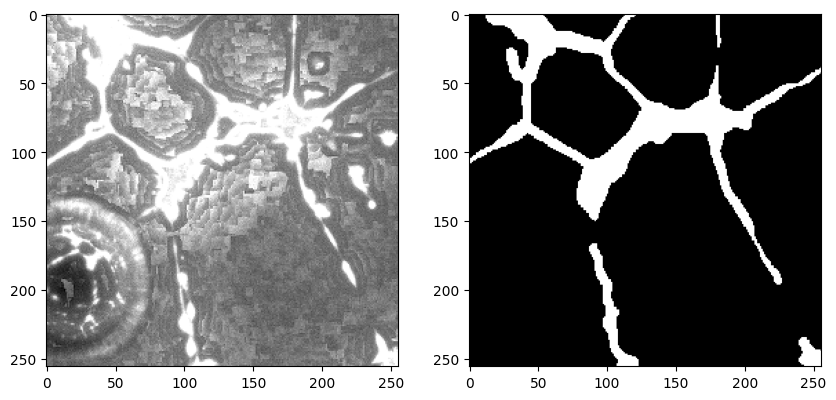

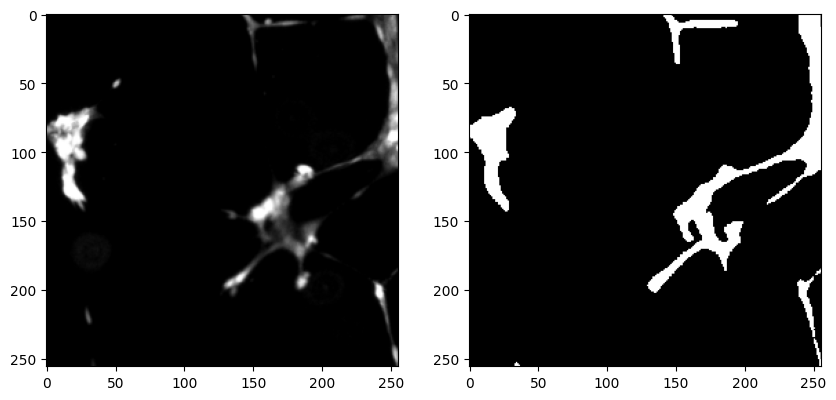

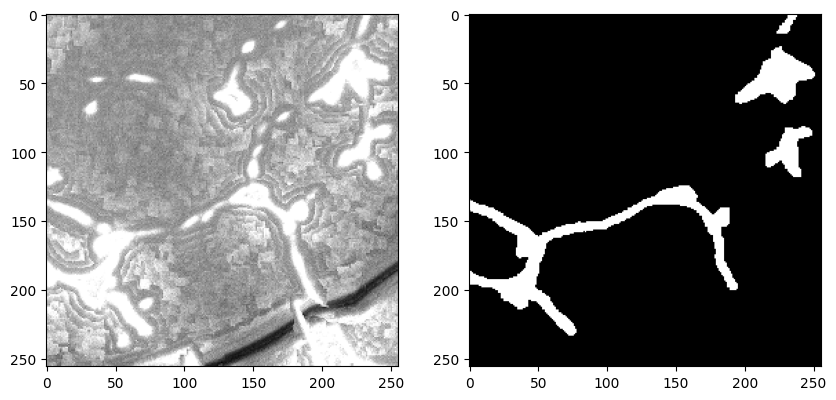

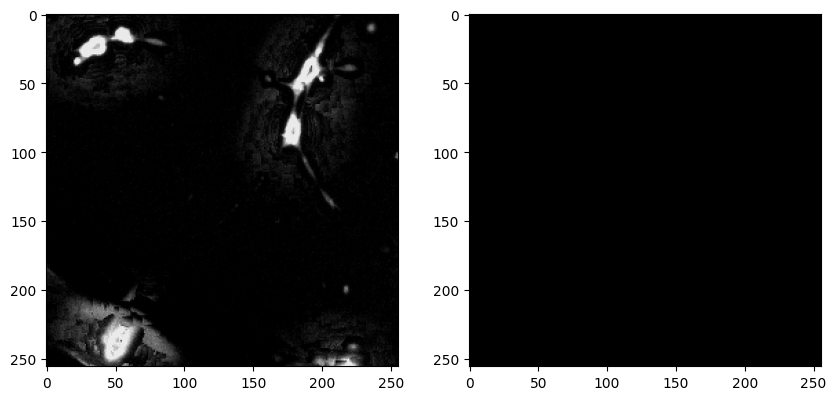

In [18]:
X, y, _ = train_gen[1]
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X[i][:,:,0], cmap='gray')
    ax[1].imshow(y[i][:,:,0], cmap='gray')
    plt.show()

### Test the validation generator

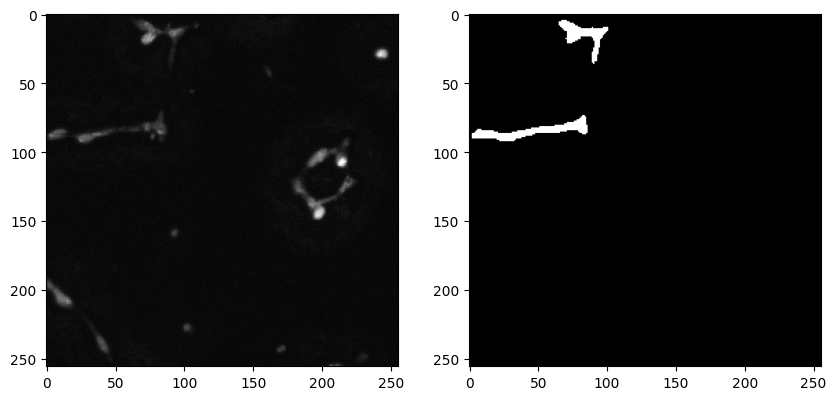

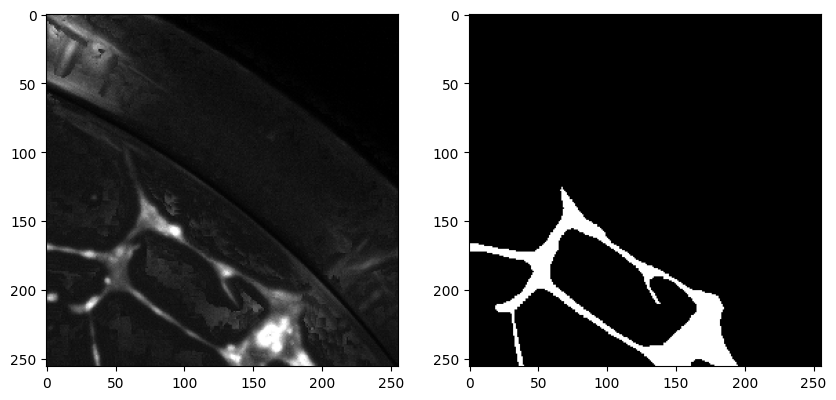

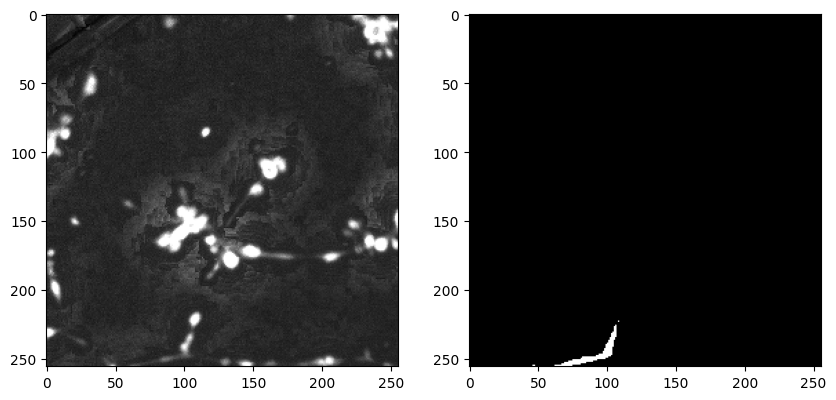

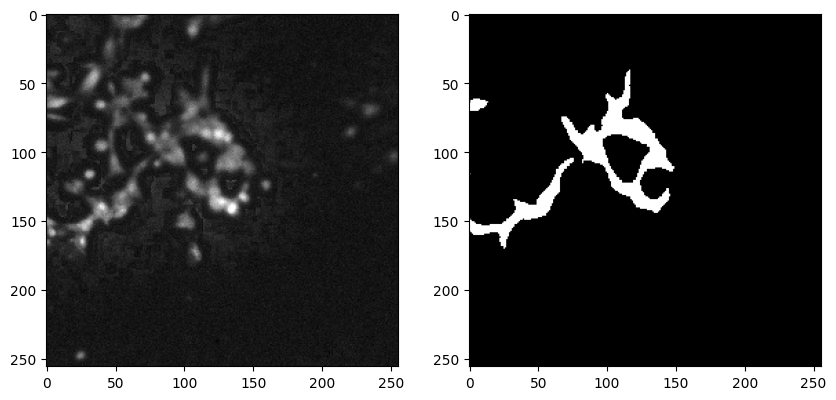

In [19]:
X, y, _ = val_gen[1]
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X[i][:,:,0], cmap='gray')
    ax[1].imshow(y[i][:,:,0], cmap='gray')
    plt.show()

## Hyperparameter search

### Specify optimizer, learning rate schedule, and number of epochs

*We'll start at a predefined learning rate and either reduce it on loss plateau or use a cyclic schedule.*

Parameters you should customize:
- `n_epochs`
- `initial_lr`
- `linear_warmup_steps` (or just leave it at the length of 1 epoch)

Extra parameters you should customize for cyclic schedule:
- `cyclic_lr_mult`
- `num_cycles`

Extra parameters you should customize for reduce lr on plateau:
- `lr_patience`
- `lr_reduction_factor`

In [36]:
n_epochs = 100
initial_lr = 2e-4

epoch_len = math.ceil(((len(train_img_paths)) * train_gen.repeat_n_times) / batch_size)
linear_warmup_steps = epoch_len

# use_cosine_decay_restarts: true to use a cyclic lr schedule, false to use ReduceLROnPlateau
use_cosine_decay_restarts = True

if use_cosine_decay_restarts:
    # cosine annealing parameters - timed so the last cycle ends at the end of training
    cycle_lr_mult = 0.5         # decrease initial lr at the end of each cycle (m_mul)
    num_cycles = 3              # number of full cycles

    # figure out what the first_decay_steps should be
    # start counting after the warmup steps
    total_steps = epoch_len * n_epochs - linear_warmup_steps

    # round up to prevent an extra restart at the end
    first_decay_steps = math.ceil(total_steps / (2**num_cycles - 1))

    learning_rate = CosineDecayRestarts(
        initial_learning_rate=initial_lr,
        first_decay_steps=first_decay_steps,
        t_mul=2.0,  # our first_decay_steps calculation assumes t_mul=2
        m_mul=cycle_lr_mult
    )
    learning_rate = optimizers.serialize(learning_rate)
else:
    # patience: number of epochs with no improvement after which learning rate will be reduced
    patience = 4
    lr_reduction_factor = 0.5
    learning_rate = initial_lr
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=lr_reduction_factor,
        patience=patience,
        verbose=1,
        mode='min'
    )

lr_schedule = models.WarmupSchedule(warmup_steps=linear_warmup_steps, after_warmup_lr=learning_rate)

weight_decay = 1e-4     # weight decay for AdamW

optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)
optimizer_config = optimizers.serialize(optimizer)

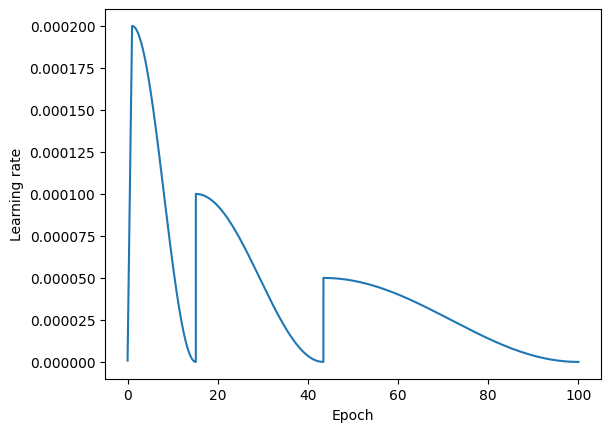

In [37]:
# Plot the learning rate over all epochs
# If ReduceLROnPlateau is used, possible LR reductions after the warmup period are not plotted
n_steps = epoch_len * n_epochs
lr_each_step = [lr_schedule(i) for i in range(n_steps)]
epoch_each_step = np.arange(1, n_steps+1) / epoch_len
plt.plot(epoch_each_step, lr_each_step)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

### Run grid search

In [38]:
hp_search_epochs = n_epochs // 10

metrics=[models.mean_iou_coef_factory(thresh=0.5)]
loss = BinaryCrossentropy()
callbacks = [] if use_cosine_decay_restarts else [reduce_lr]

gs = models.UNetXceptionGridSearch(
    save_dir="unet_grid_search",
    filter_counts_options=filter_counts_options,
    n_outputs=1,
    img_shape=target_shape,
    optimizer_cfg=optimizer_config,
    loss=loss,
    output_act="sigmoid",
    metrics=metrics,
    callbacks=callbacks
)

with custom_object_scope({'WarmupSchedule': models.WarmupSchedule}):
    gs.search(
        "mean_iou_coef",
        "max",
        train_gen,
        search_verbose=True,
        validation_data=val_gen,
        epochs=hp_search_epochs
    )

Testing filter counts: (16, 32, 64, 128)
Epoch 1/10
250/250 [==============================] - 44s 145ms/step - loss: 1.0288 - mean_iou_coef: 0.1424 - val_loss: 2.1174 - val_mean_iou_coef: 0.0741
Epoch 2/10
250/250 [==============================] - 36s 142ms/step - loss: 0.4635 - mean_iou_coef: 0.1973 - val_loss: 0.5505 - val_mean_iou_coef: 0.2226
Epoch 3/10
250/250 [==============================] - 36s 144ms/step - loss: 0.3879 - mean_iou_coef: 0.2191 - val_loss: 0.3758 - val_mean_iou_coef: 0.1925
Epoch 4/10
250/250 [==============================] - 36s 143ms/step - loss: 0.3550 - mean_iou_coef: 0.2342 - val_loss: 0.2875 - val_mean_iou_coef: 0.1837
Epoch 5/10
250/250 [==============================] - 35s 142ms/step - loss: 0.3264 - mean_iou_coef: 0.2408 - val_loss: 0.2538 - val_mean_iou_coef: 0.2449
Epoch 6/10
250/250 [==============================] - 36s 143ms/step - loss: 0.2885 - mean_iou_coef: 0.2469 - val_loss: 0.2736 - val_mean_iou_coef: 0.2049
Epoch 7/10
250/250 [=========

2023-02-23 04:26:12.160319: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-23 04:26:12.175301: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-23 04:26:12.602707: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 56s 180ms/step - loss: 0.6464 - mean_iou_coef: 0.1942 - val_loss: 3.7951 - val_mean_iou_coef: 0.1014
Epoch 2/10
250/250 [==============================] - 44s 177ms/step - loss: 0.3665 - mean_iou_coef: 0.2425 - val_loss: 1.5714 - val_mean_iou_coef: 0.0895
Epoch 3/10
250/250 [==============================] - 44s 176ms/step - loss: 0.3032 - mean_iou_coef: 0.2667 - val_loss: 0.2294 - val_mean_iou_coef: 0.3342
Epoch 4/10
250/250 [==============================] - 44s 176ms/step - loss: 0.2637 - mean_iou_coef: 0.2867 - val_loss: 0.2582 - val_mean_iou_coef: 0.1983
Epoch 5/10
250/250 [==============================] - 44s 176ms/step - loss: 0.2311 - mean_iou_coef: 0.3032 - val_loss: 0.1805 - val_mean_iou_coef: 0.2616
Epoch 6/10
250/250 [==============================] - 44s 175ms/step - loss: 0.2060 - mean_iou_coef: 0.3112 - val_loss: 0.1661 - val_mean_iou_coef: 0.2942
Epoch 7/10
250/250 [==============================] - 44s 176ms/step - loss: 0.19

In [39]:
print("Best filter counts: ", gs.best_filter_counts)
print("Best score: ", gs.best_score)
print("Best score index: ", gs.best_score_idx)

Best filter counts:  (64, 128, 256, 512)
Best score:  0.32882454991340637
Best score index:  2


## Train the model

In [ ]:
K.clear_session()

with custom_object_scope({'WarmupSchedule': models.WarmupSchedule}):
    optimizer = optimizers.deserialize(optimizer_config)

model = models.build_UNetXception(1, target_shape, filter_counts=gs.best_filter_counts,
                                  output_act="sigmoid")

metrics=[models.mean_iou_coef_factory(thresh=0.5)]

model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=metrics)

callbacks = [
    ModelCheckpoint(checkpoint_save_path, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=log_save_path, histogram_freq=1)
]

callbacks = callbacks if use_cosine_decay_restarts else callbacks + [reduce_lr]

h = model.fit(train_gen, validation_data=val_gen, epochs=n_epochs, callbacks=callbacks)

## Try out the model

In [ ]:
val_batch_num = 0
val_x, val_y, _ = val_gen[val_batch_num]
preds = model.predict(val_batch_num)

sample_idx = 0
image = val_x[sample_idx]
ground_truth = val_y[sample_idx]
prediction = preds[sample_idx]

In [ ]:
test_ex_idx = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image[:,:,0], cmap='gray')
ax[0].set_title("Image")
ax[1].imshow(ground_truth[:,:,0], cmap='gray')
ax[1].set_title("True Segmentation")
ax[2].imshow(prediction[:,:,0], cmap='gray')
ax[2].set_title("Prediction")
ax[3].imshow(np.greater(prediction, 0.5)[:,:,0], cmap='gray')
ax[3].set_title("Predicted Segmentation")

In [ ]:
# Create patch segmentor config and save it
downsample_ratio = np.divide(target_shape, crop_window)
checkpoint_file = Path(checkpoint_save_path) / "best_model.h5"
filter_counts = gs.best_filter_counts
cfg = {
    "patch_shape": crop_window,
    "checkpoint_file": checkpoint_file,
    "filter_counts": filter_counts,
    "ds_ratio": downsample_ratio,
    "norm_mean": im_mean,
    "norm_std": im_std,
    "channels": 1
}
models.save_unet_patch_segmentor_cfg(cfg)